## Laboratorio 4

### Andre Marroquin Tarot- 22266

### Sergio Orellana- 221122

### Rodrigo Mansilla 22611

LINK GIT: https://github.com/mar22266/LABORATORIOS-IA.git


# Task 1

1. Explique con sus propias palabras, qué son los grafos computaciones y cuál es su importancia para el 
cálculo de gradientes en aplicaciones como backpropagation 

        R//


2. Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo 
mejoraría el perceptrón que hizo en el laboratorio pasado? 

        R//


3. Investigue y explique cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K
Means. Explique las fórmulas (ecuaciones) que lo componen así como las asumpciones, si hay. 

        R//


4. Investigue sobre Principal Component Analysis (PCA) y responda respecto a algoritmos como K-Means: 
a. ¿Cómo podría ayudarle a mejorar la calidad de sus clusters cuando se usa K-Means?

        R//

# Task 2 y 2.1 - K-Means y Segmentación de Clientes de Banco

# 2.1.1 - K-Means

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

In [14]:
# Cargar el archivo CSV
df = pd.read_csv("bank_transactions.csv")

# ----------------------------
# Exploración de Datos
# ----------------------------

# Ver información general
df.info()

# Ver primeras filas del dataset
df.head()

# Verificar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [9]:
# Balanceo del Dataset
# Verificar distribución de clientes por género para detectar desbalance
gender_counts = df['CustGender'].value_counts()
print("Distribución por Género:")
print(gender_counts)

# Verificar distribución de transacciones por ubicación para detectar posibles desbalances
location_counts = df['CustLocation'].value_counts()
print("Distribución por Ubicación (Top 10):")
print(location_counts.head(10))

Distribución por Género:
M    765530
F    281936
T         1
Name: CustGender, dtype: int64
Distribución por Ubicación (Top 10):
MUMBAI       103595
NEW DELHI     84928
BANGALORE     81555
GURGAON       73818
DELHI         71019
NOIDA         32784
CHENNAI       30009
PUNE          25851
HYDERABAD     23049
THANE         21505
Name: CustLocation, dtype: int64


#### El dataset presenta un desbalance en la variable CustGender, donde los hombres (1) son aproximadamente tres veces más que las mujeres (0), y los valores 2 y 3 parecen errores o categorías mal definidas. Sin embargo, este desbalance no afecta el análisis, ya que en clustering no se trabaja con clases predefinidas, sino con la identificación de patrones en los datos. Por ello, no es necesario balancearlo, ya que K-Means agrupará los clientes según sus similitudes sin depender de etiquetas de clase.

In [15]:
# Preprocesamiento de Datos
# Conversión de fecha de nacimiento en edad
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')
df['Age'] = 2025 - df['CustomerDOB'].dt.year  
df.drop(columns=['CustomerDOB'], inplace=True)  

# Codificación de variables categóricas
encoder = LabelEncoder()
# LOS LABELS SE TRATAN ASI  # M -> 1, F -> 0, U -> desconocido
df['CustGender'] = encoder.fit_transform(df['CustGender'].fillna('U')) 
df['CustLocation'] = encoder.fit_transform(df['CustLocation'].fillna('Unknown'))

# Rellenar valores nulos con la mediana
df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)

# Seleccionar solo variables numéricas para clustering
features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Age']
data = df[features].dropna()

# Escalado de variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Implementación de K-Means (Sin librerías)

# Definición de métrica de desempeño principal
### Se utilizará el coeficiente de silueta porque mide qué tan bien separados y compactos están los clusters.

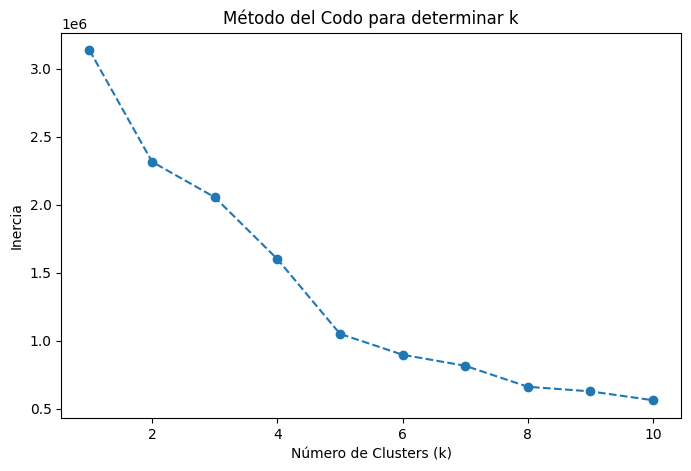

In [57]:

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def kmeans(data, k, max_iters=30):
    np.random.seed(42)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) if np.any(cluster_assignments == i) else centroids[i] for i in range(k)])
        
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return cluster_assignments, centroids

# Determinar el mejor número de clusters con el método del codo
inertia = []
k_values = range(1, 11)
for k in k_values:
    labels, centroids = kmeans(data_scaled, k)
    inertia.append(np.sum(np.min(np.linalg.norm(data_scaled[:, np.newaxis] - centroids, axis=2), axis=1)**2))

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k')
plt.show()


# Métrica de Desempeño
### Se utilizará la métrica de coeficiente de silueta para evaluar el desempeño del clustering.
### Justificación: El coeficiente de silueta mide qué tan bien separado está cada cluster y qué tan compacto es.

In [58]:
from sklearn.metrics import silhouette_score
# Seleccionar el mejor número de clusters basado en el método del codo
best_k = 4  

# Aplicar K-Means con el mejor k
labels, centroids = kmeans(data_scaled, best_k)
data['Cluster'] = labels


In [59]:
from sklearn.utils import resample

sample_size = 100000  # Usamos cien mil de muestra ya que son un millon de datos y no se puede hacer el calculo con todos debido a recursos de la maquina
data_sample, labels_sample = resample(data_scaled, data['Cluster'], n_samples=sample_size, random_state=42)

silhouette_avg = silhouette_score(data_sample, labels_sample)
print(f"Métrica de Desempeño (Coeficiente de Silueta) para {best_k} clusters: {silhouette_avg}")


Métrica de Desempeño (Coeficiente de Silueta) para 4 clusters: 0.7791020713169333


# Features seleccionados
## Justificación: PCA reduce la dimensionalidad del dataset y nos permite visualizar los clusters en dos dimensiones principales sin pérdida significativa de información

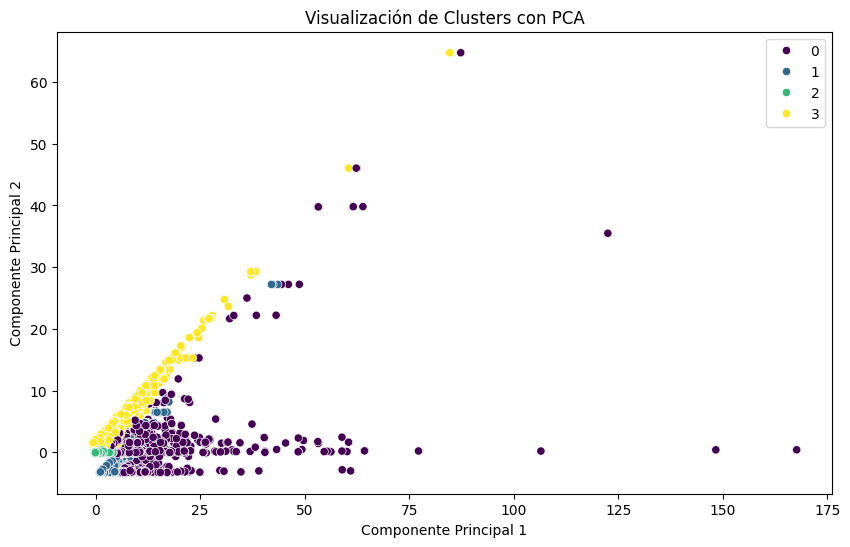

In [60]:
# Visualización de Clusters

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA')
plt.legend()
plt.show()


# Implementación de K-Means (Con librerías)

In [61]:
from sklearn.cluster import KMeans

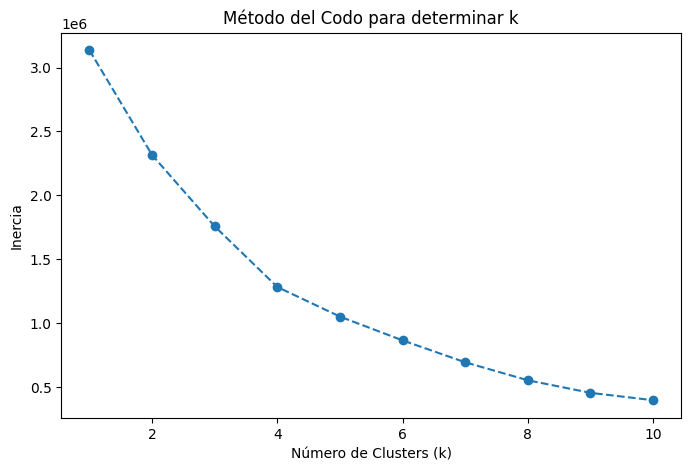

In [62]:
# Determinar el mejor número de clusters con el método del codo
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10, max_iter=300)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k')
plt.show()


In [63]:
# Seleccionar el mejor número de clusters basado en el método del codo
best_k = 4 

# Entrenar modelo K-Means con el mejor k
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(data_scaled)

In [64]:
from sklearn.utils import resample
from sklearn.metrics import silhouette_score

# Definir el tamaño de la muestra
sample_size = min(100000, len(data_scaled))  # Asegurar que no exceda el total de datos disponibles

# Tomar una muestra aleatoria del dataset
data_sample, labels_sample = resample(data_scaled, data['Cluster'], n_samples=sample_size, random_state=42)

# Calcular el coeficiente de silueta en la muestra
silhouette_avg = silhouette_score(data_sample, labels_sample)
print(f"Métrica de Desempeño (Coeficiente de Silueta) para {best_k} clusters: {silhouette_avg}")


Métrica de Desempeño (Coeficiente de Silueta) para 4 clusters: 0.841667407361284


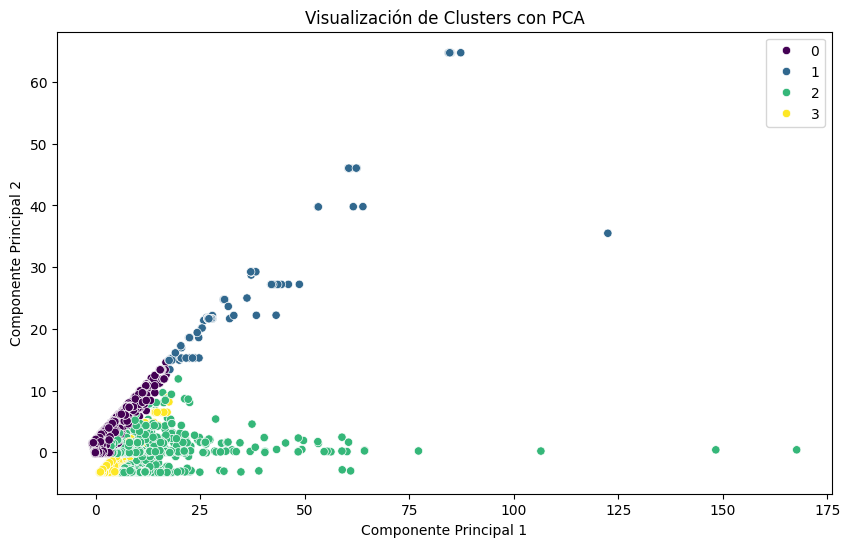

In [65]:
# Visualización de Clusters

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA')
plt.legend()
plt.show()

# Conlusion

### El modelo de K-Means con librerías es mejor, ya que obtuvo un coeficiente de silueta de 0.8417, mientras que la implementación sin librerías obtuvo 0.7791. Un coeficiente de silueta más alto indica que los clusters están mejor separados y son más compactos internamente. La diferencia se debe a que sklearn.KMeans utiliza optimizaciones avanzadas en Cython y técnicas como k-means++ para una mejor inicialización de centroides, lo que mejora la calidad del clustering y reduce la variabilidad en los resultados. 

# Task 2.2 - Mixture Modelos y Segmentación de Clientes de Banco Task 2.2.1 - Mixture Models 

# Mixture Models (Sin librerías)


### Selección de Clusters
 Para la implementación de el Mixture model se usa log likelihood con cross validation ajustando el modelo a un rango de $k's$ y graficando las iteraciones para encontrar el codo.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Cargar el dataset y convertir CustomerDOB en Age
df = pd.read_csv("bank_transactions.csv")

# Convertir CustomerDOB a datetime y calcular Age (usando 2025 como año de referencia)
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')
current_year = 2025
df['Age'] = current_year - df['CustomerDOB'].dt.year

# Seleccionar las features de interés
features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Age']
data = df[features].dropna().values

# 2) Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# (Opcional) Reducir la dimensionalidad a 2 para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Dimensión original:", X_scaled.shape)
print("Dimensión PCA:", X_pca.shape)
print("Varianza explicada por cada PC:", pca.explained_variance_ratio_)




Dimensión original: (1042802, 3)
Dimensión PCA: (1042802, 2)
Varianza explicada por cada PC: [0.35698314 0.33323985]


In [33]:
import numpy as np
from sklearn.decomposition import PCA

# Clase MixtureModels (EM) SIN librerías adicionales,
# con opción de aplicar PCA internamente.
class MixtureModels:
    def __init__(self, k=3, max_iter=1000, tol=1e-5, random_state=None, pca_components=None):
        """
        pca_components: Si no es None, se aplicará PCA para reducir la dimensionalidad a pca_components.
        """
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.pca_components = pca_components  # Número de componentes deseadas en la proyección
        self.pca = None  # Aquí se guardará el objeto PCA, si se aplica

    def _initialize(self, X):
        self.n_samples, self.n_features = X.shape
        self.weights = np.ones(self.k) / self.k
        if self.random_state is not None:
            np.random.seed(self.random_state)
        indices = np.random.choice(self.n_samples, self.k, replace=False)
        self.means = X[indices]
        self.covs = [np.eye(self.n_features) for _ in range(self.k)]
        
    def _gaussian_pdf(self, X, mean, cov):
        reg = 1e-6  # término de regularización
        cov_reg = cov + reg * np.eye(self.n_features)
        det_cov = np.linalg.det(cov_reg)
        norm_const = 1.0 / (((2 * np.pi) ** (self.n_features / 2)) * (det_cov ** 0.5))
        inv_cov = np.linalg.inv(cov_reg)
        diff = X - mean
        exponent = np.exp(-0.5 * np.sum(diff.dot(inv_cov) * diff, axis=1))
        return norm_const * exponent

    def _e_step(self, X):
        self.responsibilities = np.zeros((self.n_samples, self.k))
        for j in range(self.k):
            self.responsibilities[:, j] = self.weights[j] * self._gaussian_pdf(X, self.means[j], self.covs[j])
        eps = 1e-10
        self.responsibilities /= (np.sum(self.responsibilities, axis=1, keepdims=True) + eps)
        
    def _m_step(self, X):
        N_k = np.sum(self.responsibilities, axis=0)
        self.means = np.dot(self.responsibilities.T, X) / N_k[:, np.newaxis]
        for j in range(self.k):
            diff = X - self.means[j]
            self.covs[j] = np.dot((self.responsibilities[:, j][:, np.newaxis] * diff).T, diff) / N_k[j]
        self.weights = N_k / self.n_samples

    def log_likelihood(self, X):
        n_samples = X.shape[0]
        likelihoods = np.zeros((n_samples, self.k))
        for j in range(self.k):
            likelihoods[:, j] = self.weights[j] * self._gaussian_pdf(X, self.means[j], self.covs[j])
        eps = 1e-10
        return np.sum(np.log(np.sum(likelihoods, axis=1) + eps))

    def fit(self, X):
        # Si se especificó pca_components, aplicamos PCA a los datos antes de ajustar
        if self.pca_components is not None:
            self.pca = PCA(n_components=self.pca_components)
            X = self.pca.fit_transform(X)
        self._initialize(X)
        for i in range(self.max_iter):
            old_ll = self.log_likelihood(X)
            self._e_step(X)
            self._m_step(X)
            new_ll = self.log_likelihood(X)
            if abs(new_ll - old_ll) < self.tol:
                break
        self.X_fit = X  # Guardamos la versión transformada utilizada en el ajuste
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Si se aplicó PCA, transformamos X antes de predecir
        if self.pca_components is not None and self.pca is not None:
            X = self.pca.transform(X)
        self._e_step(X)
        return np.argmax(self.responsibilities, axis=1)


# Funciones de validación cruzada (se mantienen iguales)
def create_folds(X, n_folds, random_state=None):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)
    fold_sizes = (n_samples // n_folds) * np.ones(n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1
    folds = []
    current = 0
    for fold_size in fold_sizes:
        folds.append(indices[current:current+fold_size])
        current += fold_size
    return folds

def cross_validation_log_likelihood(X, k, n_folds=5, max_iter=1000, tol=1e-5, random_state=None):
    folds = create_folds(X, n_folds, random_state)
    log_likelihoods = []
    for i in range(n_folds):
        val_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(n_folds) if j != i])
        X_train = X[train_indices]
        X_val = X[val_indices]
        model = MixtureModels(k=k, max_iter=max_iter, tol=tol, random_state=random_state, pca_components=2)
        model.fit(X_train)
        ll_val = model.log_likelihood(X_val)
        log_likelihoods.append(ll_val)
    return np.mean(log_likelihoods)

def choose_best_k(X, candidate_ks, n_folds=5, max_iter=1000, tol=1e-5, random_state=None, sample_size=None):
    if sample_size is not None and X.shape[0] > sample_size:
        if random_state is not None:
            np.random.seed(random_state)
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X = X[indices]
        print(f"Se tomó una muestra aleatoria de {sample_size} registros para la validación cruzada.")
    results = {}
    for k in candidate_ks:
        avg_ll = cross_validation_log_likelihood(X, k, n_folds, max_iter, tol, random_state)
        results[k] = avg_ll
        print(f"k = {k}, Log Likelihood promedio en validación: {avg_ll:.4f}")
    best_k = max(results, key=results.get)
    print(f"\nEl mejor número de clusters es {best_k} con Log Likelihood promedio {results[best_k]:.4f}")
    return best_k, results




In [34]:
# Suponiendo que 'data_scaled' es tu dataset normalizado (array NumPy)
# Por ejemplo, data_scaled tiene forma (1045170, 3)
# Bloque 2: Uso de la función para determinar k (usando una muestra)
X_norm = X_pca

if X_norm.shape[0] > 100000:
    np.random.seed(42)
    indices = np.random.choice(X_norm.shape[0], 140, replace=False)
    X_sample = X_pca[indices]
else:
    X_sample = X_norm

candidate_ks = [2, 3, 4, 5, 6]
best_k, results = choose_best_k(X_sample, candidate_ks, n_folds=5, max_iter=1000, tol=1e-5, random_state=42)



k = 2, Log Likelihood promedio en validación: -83.7942
k = 3, Log Likelihood promedio en validación: -90.2101
k = 4, Log Likelihood promedio en validación: -96.7833
k = 5, Log Likelihood promedio en validación: -103.0203
k = 6, Log Likelihood promedio en validación: -117.6690

El mejor número de clusters es 2 con Log Likelihood promedio -83.7942


k = 2: Log Likelihood promedio = -83.7942
k = 3: Log Likelihood promedio = -90.2101
k = 4: Log Likelihood promedio = -96.7833
k = 5: Log Likelihood promedio = -103.0203
k = 6: Log Likelihood promedio = -117.6690


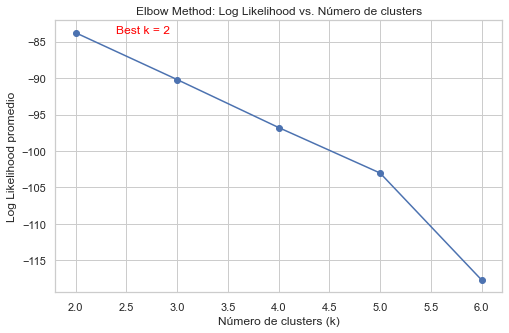

In [35]:
import matplotlib.pyplot as plt

# Usamos la misma muestra X_sample definida en el bloque anterior.
# candidate_ks ya está definido, por ejemplo:
candidate_ks = [2, 3, 4, 5, 6]

# Calculamos el log likelihood promedio para cada valor de k usando la muestra
ks = candidate_ks
likelihoods = []
for k in ks:
    ll = cross_validation_log_likelihood(X_sample, k, n_folds=5, max_iter=1000, tol=1e-5, random_state=42)
    likelihoods.append(ll)
    print(f"k = {k}: Log Likelihood promedio = {ll:.4f}")

# Determinamos el k óptimo según el máximo log likelihood
results_dict = dict(zip(ks, likelihoods))
best_k = max(results_dict, key=results_dict.get)
best_ll = results_dict[best_k]

# Graficamos la curva del método del "Elbow"
plt.figure(figsize=(8, 5))
plt.plot(ks, likelihoods, marker='o', linestyle='-')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Log Likelihood promedio")
plt.title("Elbow Method: Log Likelihood vs. Número de clusters")
plt.grid(True)

# Anotamos el k óptimo en la gráfica
plt.annotate(f"Best k = {best_k}",
             xy=(best_k, best_ll),
             xytext=(best_k+0.4, best_ll),
             fontsize=12,
             color='red')

plt.show()



## Mixture Model. 

In [39]:
# Supongamos que X_sample es una muestra aleatoria de tu dataset, por ejemplo:



# Ajuste del modelo final usando la muestra X_sample
model_final = MixtureModels(k=2, max_iter=1000, tol=1e-5, random_state=42)
model_final.fit(X_sample)

# Imprimir parámetros estimados:
print("Medias estimadas:")
print(model_final.means)
print("\nPesos estimados:")
print(model_final.weights)
print("\nCovarianzas estimadas:")
for i, cov in enumerate(model_final.covs):
    print(f"Cluster {i}:")
    print(cov)


Medias estimadas:
[[-0.16595611  0.00110793]
 [ 0.08500985  0.24211483]]

Pesos estimados:
[0.76097085 0.22569581]

Covarianzas estimadas:
Cluster 0:
[[ 0.01293569 -0.00196161]
 [-0.00196161  0.00770567]]
Cluster 1:
[[ 0.62174309 -1.16553656]
 [-1.16553656  2.914072  ]]


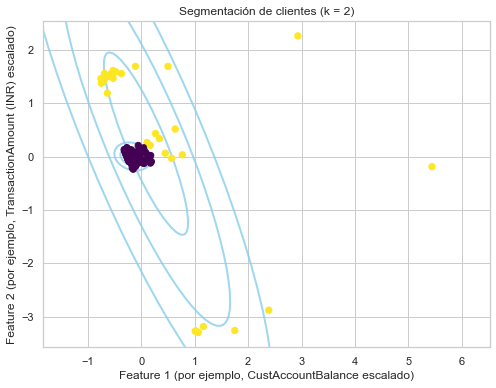

In [42]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja una elipse con una posición y covarianza dadas."""
    ax = ax or plt.gca()
    
    # Convertir la covarianza a ejes principales (solo para 2D)
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Dibuja la elipse para 1, 2 y 3 sigma
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_mixture_model(model, X, ax=None):
    """Grafica la segmentación y dibuja las elipses de covarianza para cada cluster."""
    ax = ax or plt.gca()
    # Predicción de etiquetas con el modelo ajustado
    labels = model.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, zorder=2)
    ax.axis('equal')
    
    # Factor de escalado para la transparencia de la elipse (ajustable)
    w_factor = 0.2 / model.weights.max() if model.weights.max() != 0 else 1.0
    # Dibuja la elipse de cada cluster usando las dos primeras features
    for pos, covar, w in zip(model.means, model.covs, model.weights):
        # Seleccionamos las dos primeras features
        pos_2d = pos[:2]
        cov_2d = covar[:2, :2]
        draw_ellipse(pos_2d, cov_2d, ax=ax, alpha=0.8 , edgecolor='skyblue', facecolor='none', lw=2)
    
    ax.set_xlabel("Feature 1 (por ejemplo, CustAccountBalance escalado)")
    ax.set_ylabel("Feature 2 (por ejemplo, TransactionAmount (INR) escalado)")
    ax.set_title(f"Segmentación de clientes (k = {model.k})")
    ax.grid(True)

# Graficamos la segmentación utilizando la muestra X_sample y el modelo final ajustado
plt.figure(figsize=(8, 6))
plot_mixture_model(model_final, X_sample)
plt.show()


# Definición de métrica de desempeño principal
### Se utilizará el coeficiente de silueta porque mide qué tan bien separados y compactos están los clusters.

In [43]:
from sklearn.metrics import silhouette_score

# Calcular la silueta utilizando las etiquetas obtenidas (labels) y la muestra X_sample
score = silhouette_score(X_sample, labels)
print("Silhouette Score:", score)


ValueError: Found input variables with inconsistent numbers of samples: [150, 1046198]

# Implementación de Mixture Models (Con Librerías)

## Preprocesamiento y escalado de los datos

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Carga el dataset (ajusta la ruta y las columnas según tu caso)
df = pd.read_csv("bank_transactions.csv")
features = ['CustAccountBalance', 'TransactionAmount (INR)']
data = df[features].dropna()

# Escala los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Para acelerar el ajuste, usa una muestra más pequeña (por ejemplo, 5000 registros)
sample_size = 5000 if X_scaled.shape[0] > 5000 else X_scaled.shape[0]
indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[indices]

## Definimos un GMM 


In [158]:
# Ajusta el modelo GMM con parámetros más ligeros:
gmm = GaussianMixture(n_components=25).fit(X_sample)
labels = gmm.predict(X_sample)


## Visualización de los Clusters

In [160]:
probs = gmm.predict_proba(X_sample)
print(probs[:5].round(3))



[[0.    0.    0.003 0.    0.    0.001 0.002 0.    0.    0.02  0.    0.
  0.    0.952 0.    0.    0.    0.    0.    0.    0.021 0.    0.    0.
  0.   ]
 [0.15  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.009 0.009 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.117
  0.714]
 [0.    0.    0.064 0.    0.    0.025 0.    0.    0.    0.888 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.023
  0.   ]
 [0.224 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.014 0.008 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.162
  0.59 ]
 [0.    0.    0.002 0.    0.    0.001 0.002 0.    0.    0.027 0.    0.
  0.    0.943 0.    0.    0.    0.    0.    0.    0.024 0.    0.    0.
  0.   ]]


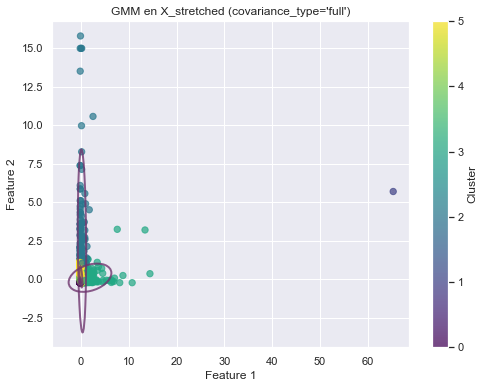

In [163]:
from sklearn.metrics import silhouette_score
gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(X_sample)
labels = gmm.predict(X_sample)
# Suponiendo que labels contiene las etiquetas predichas por GMM (o cualquier otro clustering)
# y X_sample son los datos en 2D (o N-dimensionales) usados para el clustering
sil_score = silhouette_score(X_sample, labels)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.27789108915286526


# Referencias

- RPubs - Informe #4: PCA y K-Means. (s. f.). https://rpubs.com/CarlosRodriguez_/841592

- Ramirez, J. (2021, 7 diciembre). K-means: Elbow Method and Silhouette - Jonathan Ramirez - Medium. Medium. https://medium.com/@jonathanrmzg/k-means-elbow-method-and-silhouette-e565d7ab87aa

- 

- 



